<a href="https://colab.research.google.com/github/PyMap/AUPY/blob/master/Modulo%203/03_4_BigQuery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grandes volúmenes de datos

Este notebook busca repasar algunos conceptos propios de la consulta y tratamiento de grandes volúmenes de datos. La idea es hacerlo a partir de un ejemplo práctico que nos permita tener una noción general de lo que es una "query" o consulta. Para eso, elegiremos una base de datos que nos permita utilizar servicios de consulta masiva. Algunas empresas o instituciones suelen hacer pública su información y disponibilizarla para su tratamiento.

Un caso conocido es el portal de Real Estate Properati 🏢. Ellos comparten sus datos a partir de dos alternativas: 

**a.** Los clásicos extractos descargables en formato csv (hasta un millón de registros o avisos publicados).

**b.** Y para los que busquen incoporar una herramienta nueva, BigQuery. Este es un producto de Google Cloud que facilita enormemente las consultas realizadas en conjuntos con grandes volumenes de datos. 

No son muchos los portales inmobiliarios que den acceso gratuito a una información con tanto grado de detalle ([Mercado Libre](https://developers.mercadolibre.com.ar/es_ar/guia-para-inmuebles) tiene su API propia para realizar consultas sobre avisos de propiedades inmobiliarias, pero no es un caso que abordaremos en este notebook). Por esto mismo, es que este aporte es tan valorable. Podemos consultar información de corte longitudinal (a través del tiempo) y transversal (geolocalizable para distintos países de Latinoamérica).    

El servicio de [BigQuery](https://cloud.google.com/bigquery/pricing?hl=es-419#:~:text=Nivel%20de%20uso%20gratuito,-Como%20parte%20del&text=Los%20primeros%2010%20GB%20por,de%20entrenamiento%20almacenados%20en%20BigQuery.&text=El%20primer%20TB%20de%20datos,procesan%20por%20mes%20es%20gratis.) es gratuito hasta 1TB de consultas mensuales. 

Para poder consultar un conjunto de datos es necesario antes contar con un proyecto al que podamos acceder desde nuestra [consola de google cloud](https://cloud.google.com/cloud-console/?utm_source=google&utm_medium=cpc&utm_campaign=latam-AR-all-es-dr-BKWS-all-all-trial-b-dr-1009897-LUAC0009188&utm_content=text-ad-none-any-DEV_c-CRE_436969373981-ADGP_Hybrid%20%7C%20BKWS%20-%20MIX%20%7C%20Txt%20~%20Developers_Console-KWID_43700042625134481-kwd-663366584530&utm_term=KW_%2Bgoogle%20%2Bconsole-ST_%2BGoogle%20%2BConsole&gclid=Cj0KCQjwytOEBhD5ARIsANnRjVir0Ddqu-TEqUm6RStt3eRaEnGlCuSWMKazt2zG649Xsshc4NJAie8aAsMWEALw_wcB&gclsrc=aw.ds)

Por último, en [properati data](https://www.properati.com.ar/data) nos explican cómo citarlos cada vez que usemos sus servicios. No se olviden de hacerlo! 

## El conjunto de datos de `properati` ... 

A continuación veremos cómo es el **esquema del conjunto de datos** que vamos a consultar y la estructura del comando con el que lo haremos.

* **ad_type** - Tipo de aviso (Propiedad, Desarrollo).
* **id** - Identificador del aviso. No es único: si el aviso es actualizado por la inmobiliaria (nueva versión del aviso) se crea un nuevo registro con la misma id pero distintas fechas.
* **start_date** - Fecha de alta del aviso.
* **end_date** - Fecha de baja del aviso.
* **created_on** - Fecha de alta de la primera versión del aviso.
* **place** - Campos referidos a la ubicación de la propiedad o del desarrollo.
  * **lat** - Latitud.
  * **lon** - Longitud.
  * **l1** - Nivel geopolítico 1: país.
  * **l2** - Nivel geopolítico 2: usualmente provincia.
  * **l3** - Nivel geopolítico 3: usualmente ciudad/localidad.
  * **l4 a l6** - Niveles geopolíticos 4 a 6: usualmente barrio.
* **property** - Campos relativos a la propiedad (vacío si el aviso es de un desarrollo).
  * **operation_type** - Tipo de operación (Venta, Alquiler y Alquiler temporal ).
  * **property_type** - Tipo de propiedad (Casa, Departamento, PH, etc.).
  * **rooms** - Cantidad de ambientes (útil en Argentina).
  * **bedrooms** - Cantidad de dormitorios (útil en el resto de los países).
  * **bathrooms** - Cantidad de baños.
  * **surface_total** - Superficie total en m².
  * **surface_covered** - Superficie cubierta en m².
  * **price** - Precio publicado en el anuncio.
  * **currency** - Moneda del precio publicado.
  * **price_period** - Periodo del precio (Diario, Semanal, Mensual)
  * **title** - Título del anuncio.
  * **description** - Descripción del anuncio.


# Construyendo consultas

## La consola de google cloud

<figure>
<center>
<img src='https://drive.google.com/uc?id=154OHoWl7VJagbzveSWIawfXHeQn8ghuu' />
<figcaption></figcaption></center>
</figure>

Como se puede observar, las consultas se encuentran realizadas en un lenguaje del que hablamos poco hasta el momento: SQL(Structured Query Language). Un lenguaje utilizado para trabajar con bases de datos relacionales (para nosotros, conjuntos de tablas que se encuetran relacionadas entre sí a través de una llave o id en común). 

No es la intención de este notebook adentrarse en profunidad en este lenguaje. Sino más bien conocer cómo es la estructura de una consulta y saber que la misma puede ser ejecutada a partir de un string. Tanto una consulta específica (un simple COUNT a partir de un GROUP BY), como otra masiva que nos traiga un dataset crudo (SELECT *) que podamos procesar, por ejemplo, con pandas.  

Para poder hacer una consulta en BigQuery, debemos tener en cuenta dos cosas:
```
1. El nombre del conjunto de datos
2. Los nombres de las tablas que conforman dicho conjunto. Y en particular,la fecha que figura en su título.
```

```
SELECT expr1 (AS alias1), expr2 (AS alias2), …

FROM [tabla1]

([INNER | CROSS | [LEFT | RIGHT | FULL] OUTER] JOIN [tabla2] ON condicionesJoin)

WHERE condiciones

GROUP BY expr1|alias1, expr2|alias2, …

ORDER BY expr1|alias1 [DESC|ASC], expr2|alias2 [DESC|ASC], …

LIMIT n;
```

## SQL, el lenguaje de BigQuery

La consulta abre con la declaración `SELECT`. Esta siempre hace referencia a algún tipo de operación sobre alguna de las columnas. Por ejemplo, 

`SELECT col 1, COUNT(col1) as Total`

 ... luego hay que especificar desde dónde pretendemos obtener el resultado de dicha expresión. En Big Query se suele utilizar el id del conjunto de datos. En el caso de properati:

 `FROM properati-data-public.properties_ar.properties_rent_201501`

 Entre paréntesis dejemos la operaciones opcionales. No vamos a hablar de join de tablas, asique dejemoslo a un costado y concentremonos en los aspectos útiles para hacer las primeras queries. 

 Fíjense que después de estos opcionales viene el `WHERE`. Acá es donde solemos incorporar los condicionales. Por ejemplo, en nuestro caso se puede apreciar que las tablas del conjunto `properties_ar` tiene una fecha en el nombre. Siempre con el año y el mes. Por ejemplo, 

 * properties_rent_201501
 * properties_sell_201606

 Es decir, siempre el año y el mes. Por lo tanto si nosotros quisieramos hacer una consulta a más de una tabla, incluyendo distintos rangos de fechas, deberíamos:

 ```
 FROM
    `properati-data-public.properties_ar.properties_rent_2015*`
 WHERE _TABLE_SUFFIX > '03' AND _TABLE_SUFFIX < '06'
 ```
 Lo que hacemos con el WHERE y con TABLE SUFFIX es consultar todas las tablas de alquiler del 2015, entre los meses de marzo y junio.

 Por último el GROUP BY, para agrupar las cantidades del COUNT entre todas las categorías de la variable. También se puede ordenar el resultado de manera ascendente o descendente con ORDER BY y mostrar hasta los n primeros/últimos resultados con LIMIT.

 Veamos un ejemplo de consulta bajo este esquema ...



In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery
project_id = 'tu project id'
client = bigquery.Client(project=project_id)

In [ ]:
# veamos la query completa
QUERY =  """SELECT
              property_type,
              COUNT(property_type) AS count
            FROM
              `properati-data-public.properties_ar.properties_rent_2015*`
            WHERE _TABLE_SUFFIX > '03' AND _TABLE_SUFFIX < '06'
            GROUP BY
              property_type
            ORDER BY
              count DESC"""

In [ ]:
def devuelve_consulta(query):
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df

In [ ]:
devuelve_consulta(query=QUERY)

,property_type,count
0,apartment,3091
1,house,2045
2,store,1576
3,PH,137


Recién vimos cómo hacer una consulta siguiendo el esquema del conjunto de datos tal y como está presentado en Big Query. Ahora bien, si se fijan los ejemplos de consulta en la web de properati, verán que el conjunto también se puede referenciar así `properati-dw.public.ads`. Esto nos permite consultar todo el conjunto de datos a partir del esquema de columnas propuesto en su web. 

Como primer objetivo, propongámonos extraer los registros que:
* que correspondan a Capital Federal,
* publicados durante el 2018.

... y con esto, respondamos la siguiente pregunta:
¿qué barrio de CABA tiene más desarrollos inmobiliarios publicados?

In [ ]:
# Instanciamos la consulta que vamos a hacer: ¿Qué barrio de CABA tiene más desarrollos?
QUERY =  """
          SELECT
            place.l3 AS Barrio, type AS Tipo, Count(type) AS Cantidad # en capital l3 es el barrio y l4 una subdivision. Solo usamos l3 porque hay muy pocas subdivisiones 
          FROM
            `properati-dw.public.ads`
          WHERE
            start_date >= "2018-01-01" # abrimos el periodo 2018 
            AND end_date <= "2018-12-31" # cerramos el periodo 2018
            AND place.l1 = "Argentina" # filtramos pais
            AND place.l2 = "Capital Federal" # filtramos la CABA
            AND type = "Desarrollo" # Nos quedamos solamente con los desarrollos 

          GROUP BY
            type, place.l3
            
          ORDER BY
            Cantidad DESC
          
          LIMIT
            5 # Vemos los cinco barrios con mayor cantidad de desarrollos
          """

In [ ]:
desarrollos = devuelve_consulta(query=QUERY)

In [ ]:
# Los cinco barrios con mayor cantidad de desarrollos
desarrollos

,Barrio,Tipo,Cantidad
0,Palermo,Desarrollo,7
1,Parque Patricios,Desarrollo,4
2,Villa Crespo,Desarrollo,3
3,Belgrano,Desarrollo,3
4,Caballito,Desarrollo,2


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

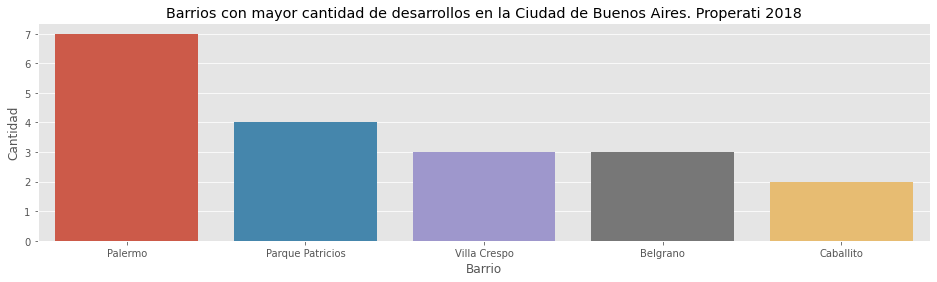

In [ ]:
# Ploteamos un gráfico de barras con seaborn  
plt.figure(figsize=(16,4))
desarrollos_plot = sns.barplot(x = "Barrio", y="Cantidad", data=desarrollos)
desarrollos_plot.set_title('Barrios con mayor cantidad de desarrollos en la Ciudad de Buenos Aires. Properati 2018');

Los cinco barrios con mayor cantidad de desarrollos durante 2018 fueron Palermo y Parque Patricios en primer lugar, seguidos de Belgrano, Villa Crespo y Recoleta.

In [ ]:
QUERY2 = """
          SELECT
            type AS Tipo, Count(type) AS Cantidad 
          FROM
            `properati-dw.public.ads`
          WHERE
            start_date >= "2018-01-01" AND end_date <= "2018-12-31" # cerramos el periodo
            AND place.l1 = "Argentina" # filtramos pais
            AND place.l2 = "Capital Federal" # filtramos la CABA 

          GROUP BY
            type 
          """

In [ ]:
query_job_2 = client.query(QUERY2)

In [ ]:
desarrollos_total = query_job_2.to_dataframe()

In [ ]:
desarrollos_total

,Tipo,Cantidad
0,Desarrollo,25
1,Propiedad,124824


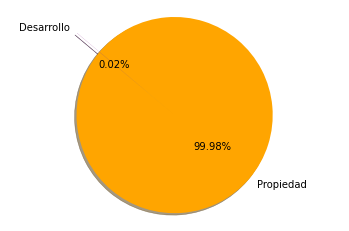

In [ ]:
# Tipos de avisos
etiqueta = ['Propiedad', 'Desarrollo']
size = [124824, 25]
color = ['orange', 'purple']
explode = (0.3, 0) 

plt.pie(size, explode=explode, labels=etiqueta, colors=color,
        autopct='%1.2f%%', shadow=True, startangle=140, pctdistance = 0.5)

plt.axis('equal');

De todas formas, los Desarrollos son una categoría con baja representatividad. Apenas llegan al 0.02% del total de propiedades. Para el periodo seleccionado, estos cinco barrios concentran casi la totalidad de los emprendimientos (19 sobre 25, es decir alrededor del 75% de lo ofertado dentro de esta categoría).

In [ ]:
# Hacemos una consulta para obtener la base de datos para 2018
QUERY3 = """
          SELECT
            * # Seleccionamos todo
          FROM
            `properati-dw.public.ads`
          WHERE
            start_date >= "2018-01-01" AND end_date <= "2018-12-31" # cerramos el periodo
            AND place.l1 = "Argentina" # filtramos pais
            AND place.l2 = "Capital Federal" # filtramos la CABA 

          LIMIT
            20000 # trabajamos solamente con 20000 avisos para no consumir demasiado en la consulta
          """

In [ ]:
query_job_3 = client.query(QUERY3)

In [ ]:
df = query_job_3.to_dataframe()

In [ ]:
# Tenemos nuestro DataFrame de propiedades de 2018. El unico problema es que los subcampos de 'place' y 'property' se guardaron como diccionario.
df.columns

Index(['type', 'type_i18n', 'country', 'id', 'start_date', 'end_date',
       'created_on', 'place', 'property', 'development'],
      dtype='object')

In [ ]:
df['place']

0        {'lat': -34.6321716, 'lon': -58.4257562, 'l1':...
1        {'lat': -34.6472077, 'lon': -58.384634, 'l1': ...
2        {'lat': -34.5779148, 'lon': -58.465901, 'l1': ...
3        {'lat': -34.624016, 'lon': -58.486498, 'l1': '...
4        {'lat': -34.601377, 'lon': -58.447825, 'l1': '...
                               ...                        
19995    {'lat': -34.5788678, 'lon': -58.4135834, 'l1':...
19996    {'lat': -34.578455, 'lon': -58.408048, 'l1': '...
19997    {'lat': -34.58522, 'lon': -58.426652, 'l1': 'A...
19998    {'lat': -34.5761071962, 'lon': -58.4227383201,...
19999    {'lat': -34.58522, 'lon': -58.426652, 'l1': 'A...
Name: place, Length: 20000, dtype: object

In [ ]:
# Convertimos en series todas las key de los diccionarios
ubicacion = df['place'].apply(pd.Series)

In [ ]:
ubicacion.head()

,lat,lon,l1,l2,l3,l4,l5,l6
0,-34.632172,-58.425756,Argentina,Capital Federal,Boedo,,,
1,-34.647208,-58.384634,Argentina,Capital Federal,Barracas,,,
2,-34.577915,-58.465901,Argentina,Capital Federal,Belgrano,,,
3,-34.624016,-58.486498,Argentina,Capital Federal,Floresta,,,
4,-34.601377,-58.447825,Argentina,Capital Federal,Villa Crespo,,,


In [ ]:
# el campo 'property'
df['property']

0        {'operation': 'Alquiler', 'operation_i18n': 'A...
1        {'operation': 'Alquiler', 'operation_i18n': 'A...
2        {'operation': 'Alquiler', 'operation_i18n': 'A...
3        {'operation': 'Venta', 'operation_i18n': 'Vent...
4        {'operation': 'Venta', 'operation_i18n': 'Vent...
                               ...                        
19995    {'operation': 'Venta', 'operation_i18n': 'Vent...
19996    {'operation': 'Venta', 'operation_i18n': 'Vent...
19997    {'operation': 'Alquiler', 'operation_i18n': 'A...
19998    {'operation': 'Alquiler', 'operation_i18n': 'A...
19999    {'operation': 'Alquiler', 'operation_i18n': 'A...
Name: property, Length: 20000, dtype: object

In [ ]:
# Convertimos en series todas las key de los diccionarios
propiedad = df['property'].apply(pd.Series)

In [ ]:
# seleccionamos algunas las columnas previas a 'place' y 'property'
columnas = df[['type', 'country', 'id', 'start_date', 'end_date', 'created_on']]

In [ ]:
columnas.head()

,type,country,id,start_date,end_date,created_on
0,Propiedad,Argentina,b'\x932\xcb\xfe\xd2\xee\xf3#\x9c\x0f\x86z9\x9f...,2018-12-08,2018-12-11,2018-12-08
1,Propiedad,Argentina,b'g\xee\rW\x97\xd5\x1c\x8fB\xad\x01\xac\xf1\xf...,2018-12-08,2018-12-12,2018-12-08
2,Propiedad,Argentina,b'\xe9\x91\xcbQk\x9c\x1bY\x88~v\x96\xbca\x80\x9c',2018-12-08,2018-12-15,2018-12-08
3,Propiedad,Argentina,b'\xd9`a\x93J\xc0\xb2\x85\xc9r\xae1\xac\xe9\xc...,2018-12-08,2018-12-29,2018-12-08
4,Propiedad,Argentina,b'F\x0b\xf7\x99\xe0\x9e\x82\xb4\x8eJ+r[\x15\x0c<',2018-12-08,2018-12-29,2018-12-08


In [ ]:
# Contatenamos todo en un unico df. Ya tenemos nuestra base de datos
df_18 = pd.concat([columnas, ubicacion, propiedad], axis=1)

In [ ]:
df_18.head()

,type,country,id,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,l5,l6,operation,operation_i18n,type,type_i18n,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description
0,Propiedad,Argentina,b'\x932\xcb\xfe\xd2\xee\xf3#\x9c\x0f\x86z9\x9f...,2018-12-08,2018-12-11,2018-12-08,-34.632172,-58.425756,Argentina,Capital Federal,Boedo,,,,Alquiler,Alquiler,PH,PH,2.0,NaN,1.0,NaN,NaN,9500.0,USD,Mensual,PH - Boedo,PH SIN EXPENSAS <br>PATIO 2.50 X 5.50 <br>COCI...
1,Propiedad,Argentina,b'g\xee\rW\x97\xd5\x1c\x8fB\xad\x01\xac\xf1\xf...,2018-12-08,2018-12-12,2018-12-08,-34.647208,-58.384634,Argentina,Capital Federal,Barracas,,,,Alquiler,Alquiler,PH,PH,3.0,2.0,1.0,158.0,78.0,13000.0,ARS,Mensual,PH EN ALQUILER,"Xintel <br><br><br><br> Alte. Brown 875, CABA ..."
2,Propiedad,Argentina,b'\xe9\x91\xcbQk\x9c\x1bY\x88~v\x96\xbca\x80\x9c',2018-12-08,2018-12-15,2018-12-08,-34.577915,-58.465901,Argentina,Capital Federal,Belgrano,,,,Alquiler,Alquiler,PH,PH,2.0,NaN,1.0,48.0,44.0,12000.0,ARS,Mensual,PH - Belgrano R,DEPARTAMENTO EN PLANTA BAJA DE DOS AMBIENTES A...
3,Propiedad,Argentina,b'\xd9`a\x93J\xc0\xb2\x85\xc9r\xae1\xac\xe9\xc...,2018-12-08,2018-12-29,2018-12-08,-34.624016,-58.486498,Argentina,Capital Federal,Floresta,,,,Venta,Venta,PH,PH,4.0,2.0,1.0,230.0,210.0,270000.0,USD,Mensual,"Venta PH 4 ambientes, Floresta",Corredor Responsable: Martin Manias - CUCICBA ...
4,Propiedad,Argentina,b'F\x0b\xf7\x99\xe0\x9e\x82\xb4\x8eJ+r[\x15\x0c<',2018-12-08,2018-12-29,2018-12-08,-34.601377,-58.447825,Argentina,Capital Federal,Villa Crespo,,,,Venta,Venta,PH,PH,3.0,2.0,1.0,80.0,68.0,180000.0,USD,Mensual,PH 3 ambientes en Villa Crespo,Corredor Responsable: Martin Manias - CUCICBA ...


In [ ]:
try:
    from google.colab import drive
    drive.mount('/drive/')
    # Exportamos el df a un csv por si acaso 
    df_18.to_csv('/drive/MyDrive/properati_2018.csv', encoding = 'UTF-8', sep = ',')
except:
    df_18.to_csv('../data/properati_2018.csv', encoding = 'UTF-8', sep = ',')